# **02. Predicting HDX deuterated fractions from MD simulations**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

In this notebook we will summarize the use of **calc_hdx.py** to predict HDX-MS data for BPTI from MD simulations. There are many empirical forward models available to predict protection factors, denoted $P_{f}$ in the equation below, from structural information.

\begin{equation*}
D_{t} = 1 - exp(\frac{-k_{int}}{P_{f}}t)
\end{equation*}

**calc_hdx.py** currently allows users to calculate protection factors using the method of [Radou](https://www.sciencedirect.com/science/article/pii/S0006349514006857?via%3Dihub), or of [Persson & Halle](https://www.pnas.org/content/112/33/10383). The 'Radou' model we use here was initially developed by [Best & Vendruscolo](https://www.sciencedirect.com/science/article/pii/S0969212605003916?via%3Dihub), and calculates protection factors as an ensemble average property of MD simulations. $N$ represents the number of heavy-atom contacts $C$ or hydrogen bonds $H$. The $\beta$ values represent individual empirical scaling factors for $C$ and $H$, first derived by [fitting to a series of experimental HDX data for 7 soluble proteins](https://www.sciencedirect.com/science/article/pii/S0969212605003916?via%3Dihub).

\begin{equation*}
lnP_{f} = <B_{C}N_{i}^{C} + B_{H}N_{i}^{H}>
\end{equation*}

First, we will go over commands that can be used to run **calc_hdx.py** and calculate predicted deuterated fractions from the BPTI MD trajectory available from D.E. Shaw Research. Then, we will make plots using the output files provided by this script.

The code below shows the arguments that need to be or optionally can be used to run **calc_hdx.py**.

In [3]:
!python $HDXER_PATH/HDXer/calc_hdx.py -h

usage: calc_hdx.py [-h] -t TRAJ [TRAJ ...] -p PARM [-s START] [-e END]
                   [-str STRIDE] [-c [CHUNKS]] [-sel SELECT] -m
                   {BestVendruscolo,PerssonHalle} [-dt TIMES [TIMES ...]]
                   [-log LOGFILE] [-seg SEGFILE] [-exp EXPFILE]
                   [-out OUTPREFIX] [-mopt METHOD_OPTIONS]
                   [-aopt ANALYSIS_OPTIONS]

optional arguments:
  -h, --help            show this help message and exit
  -t TRAJ [TRAJ ...], --traj TRAJ [TRAJ ...]
                        Trajectory/ies for analysis
  -p PARM, --parm PARM  Topology file to be used for analysis
  -s START, --start START
                        Frame at which to start (inclusive) reading each
                        trajectory. Default = 1 (every frame)
  -e END, --end END     Frame at which to end (inclusive) reading each
                        trajectory. Default = final frame
  -str STRIDE, --stride STRIDE
                        Stride at which to read the trajectory. Def

### **Mandatory inputs**

- -t: trajectory (e.g. DCD file)
- -p: topology (e.g. PDB file)
- -m: HDX prediction method (Radou or Persson-Halle)
- -seg: peptide segments for calculation of segment-averaged deuterated fractions

### **Example script**

Here is the script, *run_hdx.sh*, that was used to predict HDX dfrac using the BPTI MD trajectory.

```bash
#!/bin/bash
# A Bash script to run calc_hdx.py

python $HDXER_PATH/HDXer/calc_hdx.py -t $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_1/bpti_5pti_reimg_protonly.xtc $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_2/bpti_5pti_reimg_protonly.xtc $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_3/bpti_5pti_reimg_protonly.xtc $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_4/bpti_5pti_reimg_protonly.xtc $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_5/bpti_5pti_reimg_protonly.xtc -p $HDXER_PATH/protocol/BPTI/BPTI_simulations/Run_1/bpti_5pti_eq6_protonly.gro -m BestVendruscolo -log BPTI_calc_hdx.log -out BPTI_ -exp $HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat -seg $HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_residue_segs.txt -mopt "{ 'save_detailed' : True }"
```

Successfully running **calc_hdx.py** will create files with predicted HDX deuterated fractions for the peptide segments provided in ```$BPTI_PATH/expt_data/BPTI_residue_segs.txt```, at the default timepoints of 0.167, 1.0, 10.0 and 120.0 minutes. Files detailing the predicted protection factors and calculated intrinsic rates for each residue will also be created, the latter of which was used in the notebook 1 to generate deuterated fraction data from the experimentally-measured protection factors. Finally, the ```-mopt "{ 'save_detailed' : True }"``` flag saves output files containing the contacts and H-bonds calculated for each backbone amide at each frame of the trajectory. These files are not required for analysis with the **calc_hdx.py** script, but will be used in later notebooks.

Let's plot the predicted HDX deuterated fractions with experimental HDX deuterated fractions to see how they differ.

The functions used are the same as the ones used in the previous notebook.

In [4]:
times = np.array([0.167, 1.0, 10.0, 120.0]) # Create a NumPy array with time points in minutes

In [5]:
def read(file):
    """Read and create a pandas DataFrame for the given argument.
    
    Args:
        file: There are four possible options:
                'segs' - residue segments
                'expt' - experimental HDX deuterated fractions
                'pred' - predicted HDX deuterated fractions
                'reweighted' - reweighted HDX deuterated fractions
    
    Returns:
        df: A pandas DataFrame containing data for the given argument.
    """
    if file == 'segs':
        # Read and create a pandas DataFrame using a residue segments file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_residue_segs.txt'),
                         sep='\s+', header=None, names=['ResStr', 'ResEnd'])
    elif file == 'expt':
        # Read and create a pandas DataFrame using an experimental deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_expt_data/BPTI_expt_dfracs.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'pred':
        # Read and create a pandas DataFrame using a predicted deuterated fractions file
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_calc_hdx/BPTI_SUMMARY_segment_average_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, usecols=[2, 3, 4, 5], names=times)
    elif file == 'reweighted':
        df = pd.read_csv(os.path.expandvars('$HDXER_PATH/protocol/BPTI/BPTI_reweighting/reweighting_gamma_2x10^0_final_segment_fractions.dat'), 
                         sep='\s+', skiprows=[0], header=None, names=times)
    else:
        print("Incorrect argument given. Please choose one of the following: 'segs' 'expt' 'pred' 'reweighted'")
    return df

In [6]:
def plot_dfracs(*args):
    """Plot HDX deuterated fractions for each time point.
    
    Args:
        *args: 
            'expt' - experimental HDX deuterated fractions
            'pred' - predicted HDX deuterated fractions
            'reweighted' - reweighted HDX deuterated fractions
    """
    fig, axs = plt.subplots(len(times), 1, figsize=(12, 24))
    for i, (ax, t) in enumerate(zip(axs, times)):
        for arg in args:
            if arg in ['expt', 'pred', 'reweighted']:
                xs = np.arange(0, read(arg).iloc[:, 1].shape[0])
                ax.plot(xs, read(arg).iloc[:, i], label=arg)
                ax.set_title(f'Time = {t} min')
                ax.legend(loc='upper right')
                ax.set_xticks(xs)
                ax.set_xlim(xs[0], xs[-1])
                ax.set_xticklabels(read('segs').iloc[:, 1], rotation=90)
                ax.set_ylim(0, 1)
            else:
                print("Incorrect argument given. Please choose one or more of the following: 'expt' 'pred' 'reweighted'")
    fig.text(0.5, 0.095, 'Residue', ha='center', fontsize=22)
    fig.text(0.05, 0.5, 'HDX deuterated fractions', va='center', rotation='vertical', fontsize=22)

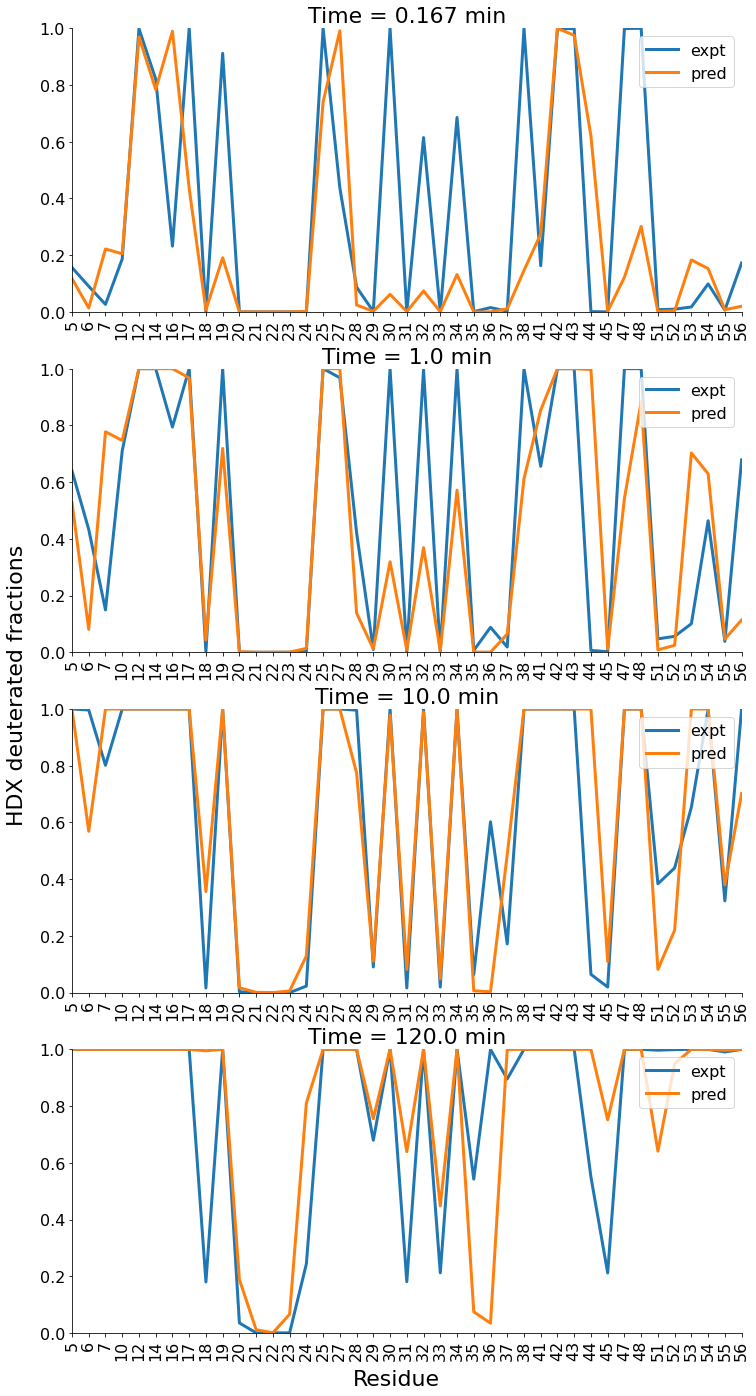

In [7]:
plot_dfracs('expt', 'pred')

Experimental deuterated fractions and predicted deuterated fractions may correlate quite well. However, when they do not match up, it is difficult to know immediately why they do not. Possible mismatch causes are:
1. Uncertainty in the experimental HDX data
2. Inaccuracy of the HDX prediction (forward) model
3. Inadequate sampling of the structural ensemble (e.g. too short MD simulations)

Another, related, possibility is that there are right structures in the structural ensemble but not in the correct proportions.

Therefore, we need a robust analysis method to obtain a structural ensemble that best-fits the experimental data, taking into account all possible forms of uncertainty.

We will use the .tmp files created by **calc_hdx.py**, which include information about the number of contacts and hydrogen bonds calculated for each amide, for **reweighting.py** in the next notebook *03_reweighting.ipynb*.